In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tabular_simple import TabularSimple, TabularNormal
from generator import Generator
from discriminator import Discriminator
from rollout_max_ent import ROLLOUT
import tensorflow as tf
from gan_trainer import GanTrainer
from dataloader import Gen_Data_loader, Dis_dataloader

/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
n_modes = 2
vocab_size = 30
vocab = range(vocab_size)
SEQ_LENGTH = 4
#tabular_model = TabularSimple(SEQ_LENGTH,n_vocabulary,n_modes)
tabular_model = TabularNormal(SEQ_LENGTH,vocab_size,n_modes)

<BarContainer object of 30 artists>

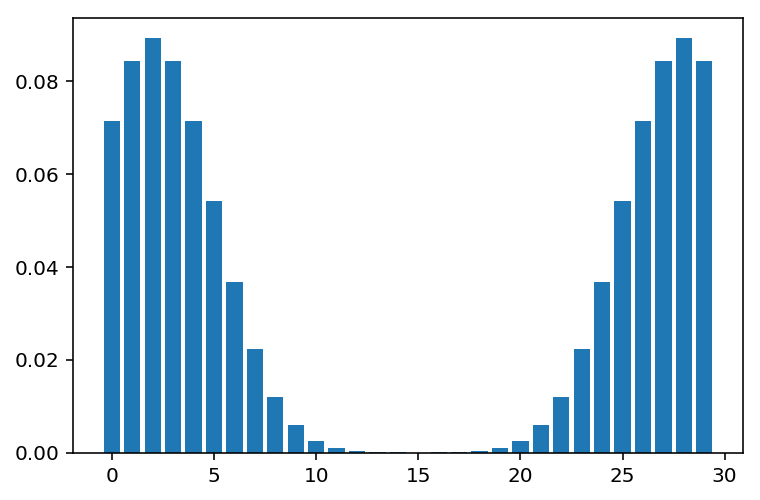

In [4]:
dist = tabular_model.table[""]
plt.bar(vocab, dist)

In [5]:
size = 10000
samples = tabular_model.sample(size)

In [6]:
positive_file = 'save/real_data_tab_simple.txt'

In [7]:
np.savetxt(positive_file,samples,fmt='%d',delimiter=' ')

In [10]:
len(list(tabular_model.table.keys()))

27931

In [11]:
g1 = tf.Graph()
g2 = tf.Graph()

In [12]:
#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 4 # embedding dimension
HIDDEN_DIM = 4 # hidden state dimension of lstm cell
#SEQ_LENGTH = 4 # sequence length
START_TOKEN = -1
PRE_EPOCH_NUM = 120 # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 256

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 4
dis_filter_sizes = [1, 2, 3, 4]
dis_num_filters = [200, 200, 200, 200]
#dis_num_filters = [10, 10, 10, 10]
dis_dropout_keep_prob = 1.0
dis_l2_reg_lambda = 0.2
dis_batch_size = 32

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
#positive_file = 'save/real_data_tab.txt'
negative_file = 'save/generator_sample_tab.txt'
negative_file_ent = 'save/generator_sample_tab_ent.txt'
#eval_file = 'save/eval_file_tab.txt'
generated_num = 10000
sequence_length = 6
g_lr = 0.01
with g1.as_default():
    generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
    discriminator = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)
    rollout = ROLLOUT(generator, 0.8)
    gen_data_loader = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    eval_data_loader = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    dis_data_loader = Dis_dataloader(BATCH_SIZE,SEQ_LENGTH)
    gan_trainer = GanTrainer(generator,discriminator,rollout,gen_data_loader,
            dis_data_loader, eval_data_loader, tabular_model,'pretrain_notebook',
            'advtrain_notebook',positive_file,negative_file,BATCH_SIZE,START_TOKEN, False)
    graph1_init_op = tf.global_variables_initializer()
    saver1 = tf.train.Saver()
with g2.as_default():
    generator_ent = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
    discriminator_ent = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)
    rollout_ent = ROLLOUT(generator_ent, 0.8)
    gen_data_loader_ent = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    eval_data_loader_ent = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    dis_data_loader_ent = Dis_dataloader(BATCH_SIZE,SEQ_LENGTH)
    gan_trainer_ent = GanTrainer(generator_ent,discriminator_ent,rollout_ent,
            gen_data_loader_ent,dis_data_loader_ent, eval_data_loader_ent, 
            tabular_model,'pretrain_notebook','advtrain_notebook',positive_file,
            negative_file_ent,BATCH_SIZE,START_TOKEN, False)
    graph2_init_op = tf.global_variables_initializer()
    saver2 = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess1 = tf.Session(config=config,graph=g1)
sess2 = tf.Session(config=config,graph=g2)

In [14]:
# run from saved checkpoint 
#saver = tf.train.Saver()
#tf.reset_default_graph()
#saver.restore(sess, 'model/pretrain_max_ent_tab.ckpt')
#saver.restore(sess, 'model/advtrain.ckpt')

In [15]:
sess1.run(graph1_init_op)
sess2.run(graph2_init_op)

In [16]:
rollout_ent.get_reward(sess2, generator_ent.generate(sess2), 1, discriminator_ent, 1.0).shape

(256, 4)

In [17]:
np.mean(rollout_ent.get_reward(sess2, generator_ent.generate(sess2), 10, discriminator_ent, 1))

-4.4703484e-07

In [18]:
np.std(rollout_ent.get_reward(sess2, generator_ent.generate(sess2), 10, discriminator_ent, 1.0))

1.3744172

In [19]:
np.sqrt(2)

1.4142135623730951

In [ ]:
gan_trainer.pretrain(sess1, 60, 20,3,
    saver1,dis_dropout_keep_prob,generated_num)
gan_trainer_ent.pretrain(sess2, 60, 20,3,
    saver2,dis_dropout_keep_prob,generated_num)

In [21]:
#EVEN WITH A VERY HIGH ENTROPY CONSTANT WE DON't see any major difference

In [22]:
2**14

16384

In [23]:
gan_trainer.get_test_loss(sess1)

3.0810921

In [24]:
for it in range(50):
    for temp, gen, disc, gan, saver, sess in zip([9999,.5],[generator,generator_ent],
            [discriminator,discriminator_ent],[gan_trainer, gan_trainer_ent],[saver1,saver2],[sess1,sess2]):
        g_loss = gan.advtrain_gen(sess,1,64,temp)
        if it % 10 == 0:
            class_ = 1
            #test_loss = - tabular_model.ll(samples = np.concatenate([gen.generate(sess) for _ in range(100)]))
            test_loss = gan.get_test_loss(sess)
            policy_ent = np.mean([sess.run(gen.pretrain_loss,
                {gen.x: gen.generate(sess) }) for _ in range(10)])
        
            disc_loss = np.mean(np.concatenate([sess.run(disc.ypred_for_auc, 
                {disc.input_x: gen.generate(sess), disc.dropout_keep_prob: 
                 dis_dropout_keep_prob})[:,class_] for _ in range(10)]))
            print("GenT: {:.4f} -  test_loss: {:.4f}, g_loss: {:.4f}, pol_ent: {:.4f}, ll_disc: {:.4f}"
                .format(temp, test_loss, g_loss,policy_ent,disc_loss))

GenT: 9999.0000 -  test_loss: 3.0812, g_loss: 77.9488, pol_ent: 3.0651, ll_disc: 0.5185
GenT: 0.5000 -  test_loss: 3.0750, g_loss: -14.9780, pol_ent: 3.0730, ll_disc: 0.4953
GenT: 9999.0000 -  test_loss: 3.1558, g_loss: -81.4075, pol_ent: 3.0505, ll_disc: 0.5251
GenT: 0.5000 -  test_loss: 3.1005, g_loss: -10.0840, pol_ent: 3.0636, ll_disc: 0.4981
GenT: 9999.0000 -  test_loss: 3.2726, g_loss: -163.8073, pol_ent: 2.9917, ll_disc: 0.5324
GenT: 0.5000 -  test_loss: 3.1345, g_loss: -62.0912, pol_ent: 3.0334, ll_disc: 0.4995
GenT: 9999.0000 -  test_loss: 3.4153, g_loss: -285.3548, pol_ent: 2.9187, ll_disc: 0.5428
GenT: 0.5000 -  test_loss: 3.1912, g_loss: -78.7277, pol_ent: 2.9997, ll_disc: 0.5013


KeyboardInterrupt: 

In [ ]:
np.mean([sess1.run(generator.pretrain_loss,
                {generator.x: generator.generate(sess1) }) for _ in range(10)])

In [ ]:
np.mean([sess2.run(generator_ent.pretrain_loss,
                {generator_ent.x: generator_ent.generate(sess2) }) for _ in range(10)])

In [ ]:
np.mean(np.concatenate([sess1.run(discriminator.ypred_for_auc, {discriminator.input_x: generator.generate(sess1), discriminator.dropout_keep_prob: dis_dropout_keep_prob})[:,class_] for _ in range(10)]))

In [ ]:
np.mean(np.concatenate([sess2.run(discriminator_ent.ypred_for_auc, {discriminator_ent.input_x: generator_ent.generate(sess2), discriminator_ent.dropout_keep_prob: dis_dropout_keep_prob})[:,class_] for _ in range(10)]))

In [ ]:
#testloss is not stable

In [ ]:
- tabular_model.ll(np.concatenate([generator_ent.generate(sess2) for _ in range(100)]))

In [ ]:
- tabular_model.ll(np.concatenate([generator.generate(sess1) for _ in range(100)]))

In [ ]:
# We see that improving the ll_disc dosn̈́'t mean that the test_loss falls.
# Also It's not super evident that the entropy is not reaaaly different
# For the entropy version with 0.25 we see that ll_disc is not going so much up while training the discrim

In [ ]:
for it in range(20):
    for temp, gen, disc, neg_file, gan, saver, sess in zip([9999,.5],[generator,generator_ent],
            [discriminator,discriminator_ent],[negative_file,negative_file_ent],[gan_trainer, gan_trainer_ent],[saver1,saver2],[sess1,sess2]):
        gan.advtrain_disc(sess,saver,1,3,
                BATCH_SIZE, generated_num, positive_file, neg_file, dis_dropout_keep_prob)
        class_ = 1
        predictions = np.array([])
        for i in range(10):
            predictions = np.concatenate((predictions,sess.run(disc.ypred_for_auc, {disc.input_x: gen.generate(sess), disc.dropout_keep_prob: dis_dropout_keep_prob})[:,class_]))
        if it % 2 == 0:
            print("DISC: GenT: {:.4f} - ll_disc: {:.4f}"
                .format(temp, np.mean(np.log(predictions))))


In [ ]:
#ll is not affected too much by training

In [ ]:
seq = [START_TOKEN]

In [ ]:
h_t = generator.h0
for token in seq:
    x_t = tf.nn.embedding_lookup(generator.g_embeddings, [token]*BATCH_SIZE)
    h_t = generator.g_recurrent_unit(x_t, h_t)  # hidden_memory_tuple
    o_t = generator.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0 = sess1.run(tf.nn.softmax(o_t))[0,:]
plt.bar(vocab, dist0)
#sess1.run(h_t)

In [ ]:
h_t = generator_ent.h0
for token in seq:
    x_t = tf.nn.embedding_lookup(generator_ent.g_embeddings, [token]*BATCH_SIZE)
    h_t = generator_ent.g_recurrent_unit(x_t, h_t)  # hidden_memory_tuple
    o_t = generator_ent.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0_ent = sess2.run(tf.nn.softmax(o_t))[0,:]
plt.bar(vocab, dist0_ent)
#sess1.run(h_t)

In [ ]:
plt.bar(vocab,tabular_model.table[""])